# VAERS Influenza × Hypertension Pipeline (Python) – 1990–2025

Pipeline:
- Load multi-year (1990–2025)
- Filter seasonal influenza vaccines (exclude H1N1), classify TIA/QIA/FLUX
- Identify HTN via keyword search in text fields
- Create outcome/time variables
- Build AE features from SYMPTOM1–5 (freq>=10)
- PSM (nearest neighbor + caliper) + SMD balance check
- Kaplan–Meier by vaccine type
- Cox per-AE + BH-FDR
- PH test for top signals
- Sensitivity: REPORT_DELAY >= 7


In [1]:

# =========================
# 0) Install deps (run once)
# =========================
import sys
!{sys.executable} -m pip -q install pandas numpy scikit-learn lifelines statsmodels matplotlib

# =========================
# Imports
# =========================
import os, re, warnings
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import proportional_hazard_test

from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(12345)


In [2]:

# =========================
# 1) Paths & years (EDIT IF NEEDED)
# =========================
# IMPORTANT: dùng raw-string r"" để tránh lỗi backslash trên Windows
vaers_dir = r"C:\tài liệu của hoàn\bai bao\AllVAERSDataCSVS"

years = list(range(1990, 2026))  # 1990..2025
report_delay_threshold = 7       # sensitivity


In [3]:

# =========================
# 2) Quick path check
# =========================
print("vaers_dir =", vaers_dir)
print("exists   =", os.path.exists(vaers_dir))

if not os.path.exists(vaers_dir):
    raise RuntimeError("❌ vaers_dir không tồn tại. Hãy kiểm tra lại đường dẫn.")

sample = sorted([f for f in os.listdir(vaers_dir) if f.lower().endswith(".csv")])[:15]
print("First CSV files:", sample)

need_1990 = ["1990VAERSDATA.csv","1990VAERSSYMPTOMS.csv","1990VAERSVAX.csv"]
print("Check 1990 triplet:")
for n in need_1990:
    print(" -", n, "=>", os.path.exists(os.path.join(vaers_dir, n)))


vaers_dir = C:\tài liệu của hoàn\bai bao\AllVAERSDataCSVS
exists   = True
First CSV files: ['1990VAERSDATA.csv', '1990VAERSSYMPTOMS.csv', '1990VAERSVAX.csv', '1991VAERSDATA.csv', '1991VAERSSYMPTOMS.csv', '1991VAERSVAX.csv', '1992VAERSDATA.csv', '1992VAERSSYMPTOMS.csv', '1992VAERSVAX.csv', '1993VAERSDATA.csv', '1993VAERSSYMPTOMS.csv', '1993VAERSVAX.csv', '1994VAERSDATA.csv', '1994VAERSSYMPTOMS.csv', '1994VAERSVAX.csv']
Check 1990 triplet:
 - 1990VAERSDATA.csv => True
 - 1990VAERSSYMPTOMS.csv => True
 - 1990VAERSVAX.csv => True


In [4]:

# =========================
# 2b) Robust CSV reader (handles VAERS encodings)
# =========================
import pandas as pd

def read_csv_robust(path: str, **kwargs) -> pd.DataFrame:
    """Try common encodings used in VAERS files; fall back with replacement."""
    encodings = ["utf-8", "utf-8-sig", "cp1252", "latin1"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, encoding_errors="strict", **kwargs)
        except UnicodeDecodeError as e:
            last_err = e
            continue
    # last resort: replace bad bytes so the pipeline can continue
    return pd.read_csv(path, encoding="cp1252", encoding_errors="replace", **kwargs)



In [5]:

# =========================
# 3) Load multi-year VAERS (1990–2025)
# =========================
loaded = []
missing_years = []

for y in years:
    f_data = os.path.join(vaers_dir, f"{y}VAERSDATA.csv")
    f_sym  = os.path.join(vaers_dir, f"{y}VAERSSYMPTOMS.csv")
    f_vax  = os.path.join(vaers_dir, f"{y}VAERSVAX.csv")

    if not (os.path.exists(f_data) and os.path.exists(f_sym) and os.path.exists(f_vax)):
        missing_years.append(y)
        continue

    data = read_csv_robust(f_data, low_memory=False)
    sym  = read_csv_robust(f_sym,  low_memory=False)
    vax  = read_csv_robust(f_vax,  low_memory=False)

    data.columns = data.columns.str.upper()
    sym.columns  = sym.columns.str.upper()
    vax.columns  = vax.columns.str.upper()

    loaded.append((data, sym, vax))

if len(loaded) == 0:
    raise RuntimeError("❌ Không load được năm nào. Kiểm tra tên file trong folder (phải đúng YYYYVAERSDATA.csv, ...).")

vaers_data = pd.concat([x[0] for x in loaded], ignore_index=True, sort=False)
vaers_sym  = pd.concat([x[1] for x in loaded], ignore_index=True, sort=False)
vaers_vax  = pd.concat([x[2] for x in loaded], ignore_index=True, sort=False)

print("✅ Loaded OK")
print("VAERSDATA rows:", len(vaers_data))
print("VAERSSYMPTOMS rows:", len(vaers_sym))
print("VAERSVAX rows:", len(vaers_vax))
print("Missing years:", len(missing_years), "| first:", missing_years[:10])


✅ Loaded OK
VAERSDATA rows: 1972415
VAERSSYMPTOMS rows: 2521999
VAERSVAX rows: 2494138
Missing years: 0 | first: []


In [6]:

# =========================
# 4) Helpers
# =========================
def safe_col(df: pd.DataFrame, col: str):
    colu = col.upper()
    return df[colu] if colu in df.columns else pd.Series([np.nan]*len(df), index=df.index)

def parse_mdy(s: pd.Series):
    return pd.to_datetime(s, errors="coerce", format="%m/%d/%Y")

def season_from_month(m):
    if m in (3,4,5): return "Spring"
    if m in (6,7,8): return "Summer"
    if m in (9,10,11): return "Fall"
    if m in (12,1,2): return "Winter"
    return np.nan

# Region approx by state code (optional)
WEST = set(["WA","OR","CA","AK","HI","ID","MT","WY","NV","UT","AZ","CO","NM"])
MIDWEST = set(["ND","SD","NE","KS","MN","IA","MO","WI","IL","IN","MI","OH"])
NORTHEAST = set(["ME","NH","VT","MA","RI","CT","NY","NJ","PA"])
SOUTH = set(["DE","MD","DC","VA","WV","NC","SC","GA","FL","KY","TN","MS","AL","OK","TX","AR","LA"])

def region_from_state(st):
    if pd.isna(st): return "Overseas"
    st = str(st).upper().strip()
    if st in WEST: return "West"
    if st in MIDWEST: return "Midwest"
    if st in NORTHEAST: return "Northeast"
    if st in SOUTH: return "South"
    return "Overseas"

def logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))


In [7]:

# =========================
# 5) Filter seasonal influenza vaccines, exclude H1N1, classify TIA/QIA/FLUX
# =========================
vax_type = safe_col(vaers_vax, "VAX_TYPE").astype(str).str.upper()
vax_name = safe_col(vaers_vax, "VAX_NAME").astype(str).str.upper()

is_flu = (vax_type == "FLU") | vax_name.str.contains(r"\bFLU\b|FLU3|FLU4|FLUA|FLUC|FLUR|FLUN", regex=True, na=False)
not_h1n1 = ~vax_name.str.contains("H1N1", na=False)

vax_flu = vaers_vax.loc[is_flu & not_h1n1, ["VAERS_ID"]].copy()
vax_flu["VAX_NAME"] = vax_name[is_flu & not_h1n1].values

def classify_vax(nm: str):
    nm = str(nm).upper()
    if re.search(r"FLU3|FLUA3|FLUC3|FLUR3|FLUN3", nm): return "TIA"
    if re.search(r"FLU4|FLUA4|FLUC4|FLUR4|FLUN4", nm): return "QIA"
    return "FLUX"

vax_flu["VAX_GROUP"] = vax_flu["VAX_NAME"].apply(classify_vax)
vax_flu = vax_flu[["VAERS_ID","VAX_GROUP"]].drop_duplicates()

print("Influenza vaccine cases:", len(vax_flu))


Influenza vaccine cases: 47736


In [8]:

# =========================
# 6) Join with VAERSDATA and identify HTN (keyword search)
# =========================
df = vaers_data.merge(vax_flu, on="VAERS_ID", how="inner")

history = safe_col(df, "HISTORY").astype(str).str.upper()
other_meds = safe_col(df, "OTHER_MEDS").astype(str).str.upper()
cur_ill = safe_col(df, "CUR_ILL").astype(str).str.upper()

med_text = (history.fillna("") + " | " + other_meds.fillna("") + " | " + cur_ill.fillna(""))
htn_pattern = r"HIGH BLOOD PRESSURE|HYPERTENSION|\bHBP\b|\bHTN\b|BLOOD PRESSURE"

df = df[med_text.str.contains(htn_pattern, regex=True, na=False)].copy()
print("HTN influenza cases:", len(df))


HTN influenza cases: 4032


In [9]:

# =========================
# 7) Outcome + time variables + confounders
# =========================
df["AGE_YRS"] = pd.to_numeric(safe_col(df, "AGE_YRS"), errors="coerce")
df["SEX"] = safe_col(df, "SEX").astype(str).str.upper().replace({"": np.nan})

df["VAX_DATE"] = parse_mdy(safe_col(df, "VAX_DATE"))
df["ONSET_DATE"] = parse_mdy(safe_col(df, "ONSET_DATE"))
df["RPT_DATE"] = parse_mdy(safe_col(df, "RPT_DATE"))

numdays = pd.to_numeric(safe_col(df, "NUMDAYS"), errors="coerce")
time_days = numdays.copy()
mask_na = time_days.isna()
time_days.loc[mask_na] = (df.loc[mask_na, "ONSET_DATE"] - df.loc[mask_na, "VAX_DATE"]).dt.days
df["TIME_DAYS"] = time_days

df["REPORT_DELAY"] = (df["RPT_DATE"] - df["VAX_DATE"]).dt.days

df["RECOVD"] = safe_col(df, "RECOVD").astype(str).str.upper()
df["Y_nonrecovery"] = np.where(df["RECOVD"].eq("Y"), 0, 1).astype(int)

df = df[(df["AGE_YRS"] >= 18) & df["TIME_DAYS"].notna() & (df["TIME_DAYS"] >= 0)].copy()

# Confounders
bins = [18,60,65,70,75,80,10**9]
labels = ["18-59","60-64","65-69","70-74","75-79","80+"]

df["AGE_GROUP"] = pd.cut(df["AGE_YRS"], bins=bins, labels=labels, right=False)

state = safe_col(df, "STATE").astype(str).str.upper()
df["REGION"] = state.apply(region_from_state)

ref_date = df["VAX_DATE"].fillna(df["ONSET_DATE"])
df["SEASON"] = ref_date.dt.month.apply(season_from_month)
df["COVID_PERIOD"] = (ref_date.dt.year >= 2020).astype(int)

df = df[df["AGE_GROUP"].notna() & df["SEASON"].notna()].copy()

# Serious flag (subgroup)
def yflag(col):
    return safe_col(df, col).astype(str).str.upper().eq("Y")

df["SERIOUS"] = (yflag("DIED") | yflag("L_THREAT") | yflag("HOSPITAL") | yflag("DISABLE")).astype(int)

print("After filters:", len(df))
print(df[["Y_nonrecovery","SERIOUS","COVID_PERIOD"]].value_counts().head(10))


After filters: 3807
Y_nonrecovery  SERIOUS  COVID_PERIOD
1              0        0               1036
                        1                898
0              0        0                802
                        1                517
1              1        0                198
                        1                160
0              1        1                118
                        0                 78
Name: count, dtype: int64


In [10]:

# =========================
# 8) AE features from VAERSSYMPTOMS (SYMPTOM1–5), freq>=10
#    IMPORTANT FIX:
#    - DO NOT melt the full VAERSSYMPTOMS table (1990–2025) -> too huge and can crash/pandas bug.
#    - First filter VAERSSYMPTOMS to ONLY VAERS_IDs in your analysis cohort (df).
# =========================
sym_cols = [c for c in ["SYMPTOM1","SYMPTOM2","SYMPTOM3","SYMPTOM4","SYMPTOM5"] if c in vaers_sym.columns]
if not sym_cols:
    raise RuntimeError("❌ Không tìm thấy SYMPTOM1..5 trong VAERSSYMPTOMS")

# 1) Filter symptoms to cohort VAERS_IDs (massive speed/memory win)
cohort_ids = df["VAERS_ID"].dropna().unique()
sym5 = vaers_sym.loc[vaers_sym["VAERS_ID"].isin(cohort_ids), ["VAERS_ID"] + sym_cols].copy()

# 2) Standardize text
for c in sym_cols:
    sym5[c] = (sym5[c].astype(str)
                      .str.upper()
                      .replace({"NAN": "", "NONE": "", "": ""}))

# 3) Long format without full melt overhead
sym_long = (
    sym5.set_index("VAERS_ID")[sym_cols]
        .stack(dropna=False)
        .reset_index()
        .rename(columns={"level_1": "SYM_SLOT", 0: "PT"})
)
sym_long["PT"] = sym_long["PT"].astype(str).str.strip()
sym_long = sym_long[sym_long["PT"].ne("")].copy()

# 4) Keep terms with frequency >= 10 (like paper)
freq = sym_long["PT"].value_counts()
keep_terms = freq[freq >= 10].index

if len(keep_terms) == 0:
    raise RuntimeError("❌ Không có AE term nào có tần suất >= 10 sau khi lọc cohort. "
                       "Hãy giảm threshold (vd >=5) hoặc kiểm tra dữ liệu.")

sym_long = sym_long[sym_long["PT"].isin(keep_terms)].copy()

# 5) Create sparse-ish wide matrix via crosstab
# (This avoids a pivot_table internal bug seen with huge data)
ae_wide = pd.crosstab(sym_long["VAERS_ID"], sym_long["PT"])
ae_wide = (ae_wide > 0).astype(int).reset_index()

df = df.merge(ae_wide, on="VAERS_ID", how="left")
ae_cols = [c for c in ae_wide.columns if c != "VAERS_ID"]
df[ae_cols] = df[ae_cols].fillna(0).astype(int)

print("Cohort VAERS_IDs:", len(cohort_ids))
print("AE terms kept (>=10):", len(keep_terms))
print("Rows after AE merge:", len(df))


Cohort VAERS_IDs: 3527
AE terms kept (>=10): 316
Rows after AE merge: 3807


In [11]:

# =========================
# 9) Propensity Score Matching (PSM): nearest neighbor 1:1 + caliper
# =========================
ps_covars = ["AGE_GROUP","SEX","REGION","SEASON"]
X = pd.get_dummies(df[ps_covars].astype(str), drop_first=True)
y = df["Y_nonrecovery"].astype(int)

ps_model = LogisticRegression(max_iter=3000, solver="lbfgs")
ps_model.fit(X, y)
ps = ps_model.predict_proba(X)[:,1]
df["ps"] = ps
df["logit_ps"] = logit(ps)

caliper = 0.2 * np.nanstd(df["logit_ps"].values)

treated = df[df["Y_nonrecovery"]==1].copy()
control = df[df["Y_nonrecovery"]==0].copy()

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["logit_ps"]].values)
dist, idx = nn.kneighbors(treated[["logit_ps"]].values, n_neighbors=1)

treated["match_dist"] = dist.flatten()
treated["control_index"] = idx.flatten()

treated_m = treated[treated["match_dist"] <= caliper].copy()
control_m = control.iloc[treated_m["control_index"].values].copy()

matched = pd.concat([treated_m.assign(_group="treated"), control_m.assign(_group="control")], ignore_index=True)

print("Matched N:", len(matched), "| treated:", len(treated_m), "| control:", len(control_m))


Matched N: 4582 | treated: 2291 | control: 2291


In [12]:

# =========================
# 9b) Balance diagnostics: SMD for categorical covariates
# =========================
def smd_categorical(series, group01):
    d = pd.get_dummies(series.astype(str), drop_first=False)
    g1 = d[group01==1]
    g0 = d[group01==0]
    p1 = g1.mean(axis=0)
    p0 = g0.mean(axis=0)
    p = (p1 + p0)/2
    denom = np.sqrt(p*(1-p) + 1e-12)
    smd = ((p1 - p0)/denom).abs()
    return smd.max()

g = (matched["_group"]=="treated").astype(int)

smd_rows = []
for c in ["AGE_GROUP","SEX","REGION","SEASON","COVID_PERIOD"]:
    smd_rows.append({"var": c, "SMD": float(smd_categorical(matched[c], g))})

smd_table = pd.DataFrame(smd_rows).sort_values("SMD", ascending=False)
smd_table


,var,SMD
4,COVID_PERIOD,0.853878
1,SEX,0.069009
0,AGE_GROUP,0.010729
3,SEASON,0.007574
2,REGION,0.007379


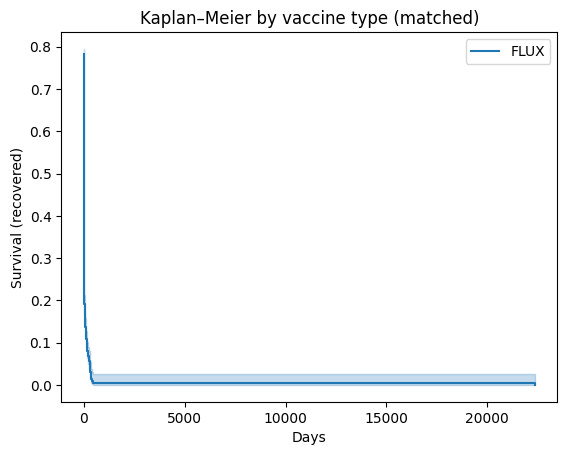

In [13]:

# =========================
# 10) Kaplan–Meier by vaccine type (matched)
# =========================
kmf = KaplanMeierFitter()
plt.figure()
for grp, dsub in matched.groupby("VAX_GROUP"):
    kmf.fit(dsub["TIME_DAYS"], event_observed=dsub["Y_nonrecovery"], label=str(grp))
    kmf.plot_survival_function()
plt.xlabel("Days")
plt.ylabel("Survival (recovered)")
plt.title("Kaplan–Meier by vaccine type (matched)")
plt.show()


In [14]:

# =========================
# 11) Cox per-AE (adjusted) + BH-FDR
# =========================
base_covars = ["AGE_GROUP","SEX","REGION","SEASON","COVID_PERIOD"]
base_X = pd.get_dummies(matched[base_covars].astype(str), drop_first=True)

results = []
for ae in ae_cols:
    if matched[ae].nunique() <= 1:
        continue

    cox_df = pd.concat([
        matched[["TIME_DAYS","Y_nonrecovery"]].reset_index(drop=True),
        base_X.reset_index(drop=True),
        matched[[ae]].reset_index(drop=True)
    ], axis=1)

    cph = CoxPHFitter()
    try:
        cph.fit(cox_df, duration_col="TIME_DAYS", event_col="Y_nonrecovery")
        hr = float(np.exp(cph.params_[ae]))
        ci = cph.confidence_intervals_.loc[ae].values
        ci_low = float(np.exp(ci[0]))
        ci_high = float(np.exp(ci[1]))
        p = float(cph.summary.loc[ae, "p"])
        results.append((ae, hr, ci_low, ci_high, p))
    except Exception:
        continue

cox_res = pd.DataFrame(results, columns=["AE","HR","CI_low","CI_high","p"])
if len(cox_res):
    cox_res["q"] = multipletests(cox_res["p"].values, method="fdr_bh")[1]
    cox_res = cox_res.sort_values(["q","p"])

cox_res.head(30)


,AE,HR,CI_low,CI_high,p,q
237,PRODUCT STORAGE ERROR,5.940894,4.823335,7.317390,4.904801e-63,1.549917e-60
66,COUGH,0.251977,0.200206,0.317136,7.349693e-32,1.161252e-29
144,INJECTED LIMB MOBILITY DECREASED,2.713471,2.274153,3.237656,1.615964e-28,1.702148e-26
81,DYSPNOEA,0.312978,0.254198,0.385351,7.040992e-28,5.562384e-26
156,INJECTION SITE PAIN,1.867829,1.663734,2.096962,3.588880e-26,2.268172e-24
223,PAIN IN EXTREMITY,1.779161,1.595672,1.983749,3.242977e-25,1.707968e-23
67,COVID-19,0.211008,0.156417,0.284652,2.287618e-24,1.032696e-22
169,LABORATORY TEST ABNORMAL,0.064794,0.038047,0.110345,7.178698e-24,2.835586e-22
260,SARS-COV-2 TEST POSITIVE,0.236970,0.172640,0.325271,5.107186e-19,1.793190e-17
140,INFLUENZA,0.096633,0.055584,0.167997,1.211904e-16,3.829616e-15


In [15]:

# Save outputs next to the VAERS folder (same parent)
out_dir = os.path.join(os.path.dirname(vaers_dir), "vaers_outputs")
os.makedirs(out_dir, exist_ok=True)

out_main = os.path.join(out_dir, "cox_per_ae_fdr_python.csv")
cox_res.to_csv(out_main, index=False)

print("Saved:", out_main)


Saved: C:\tài liệu của hoàn\bai bao\vaers_outputs\cox_per_ae_fdr_python.csv


In [16]:

# =========================
# 12) PH assumption checks for top signals
# =========================
top_ae = cox_res.loc[cox_res["q"] < 0.05, "AE"].head(10).tolist()
ph_rows = []

for ae in top_ae:
    cox_df = pd.concat([
        matched[["TIME_DAYS","Y_nonrecovery"]].reset_index(drop=True),
        base_X.reset_index(drop=True),
        matched[[ae]].reset_index(drop=True)
    ], axis=1)

    cph = CoxPHFitter()
    try:
        cph.fit(cox_df, duration_col="TIME_DAYS", event_col="Y_nonrecovery")
        test = proportional_hazard_test(cph, cox_df, time_transform="rank")
        ae_p = float(test.summary.loc[ae, "p"])
        ph_rows.append((ae, ae_p))
    except Exception:
        continue

ph_df = pd.DataFrame(ph_rows, columns=["AE","PH_test_p_for_AE"])
ph_df


,AE,PH_test_p_for_AE
0,PRODUCT STORAGE ERROR,0.416694
1,COUGH,0.015056
2,INJECTED LIMB MOBILITY DECREASED,0.027866
3,DYSPNOEA,0.061048
4,INJECTION SITE PAIN,0.015871
5,PAIN IN EXTREMITY,0.179320
6,COVID-19,0.070948
7,LABORATORY TEST ABNORMAL,0.052543
8,SARS-COV-2 TEST POSITIVE,0.020466
9,INFLUENZA,0.385375


In [17]:

out_ph = os.path.join(out_dir, "ph_assumption_top_ae_python.csv")
ph_df.to_csv(out_ph, index=False)
print("Saved:", out_ph)


Saved: C:\tài liệu của hoàn\bai bao\vaers_outputs\ph_assumption_top_ae_python.csv


In [18]:

# =========================
# 13) Sensitivity: REPORT_DELAY >= threshold (matched)
# =========================
matched_sens = matched[(matched["REPORT_DELAY"].notna()) & (matched["REPORT_DELAY"] >= report_delay_threshold)].copy()
print("Matched sensitivity N:", len(matched_sens))

if len(matched_sens) < 500:
    print("⚠️ Sensitivity sample nhỏ, có thể ít kết quả.")
else:
    base_X_s = pd.get_dummies(matched_sens[base_covars].astype(str), drop_first=True)

    res_s = []
    for ae in ae_cols:
        if ae not in matched_sens.columns or matched_sens[ae].nunique() <= 1:
            continue

        cox_df = pd.concat([
            matched_sens[["TIME_DAYS","Y_nonrecovery"]].reset_index(drop=True),
            base_X_s.reset_index(drop=True),
            matched_sens[[ae]].reset_index(drop=True)
        ], axis=1)

        cph = CoxPHFitter()
        try:
            cph.fit(cox_df, duration_col="TIME_DAYS", event_col="Y_nonrecovery")
            hr = float(np.exp(cph.params_[ae]))
            ci = cph.confidence_intervals_.loc[ae].values
            res_s.append((ae, hr, float(np.exp(ci[0])), float(np.exp(ci[1])), float(cph.summary.loc[ae,"p"])))
        except Exception:
            continue

    cox_sens = pd.DataFrame(res_s, columns=["AE","HR","CI_low","CI_high","p"])
    if len(cox_sens):
        cox_sens["q"] = multipletests(cox_sens["p"].values, method="fdr_bh")[1]
        cox_sens = cox_sens.sort_values(["q","p"])

    out_sens = os.path.join(out_dir, "cox_per_ae_fdr_sensitivity_reportdelay_python.csv")
    cox_sens.to_csv(out_sens, index=False)
    print("Saved:", out_sens)
    display(cox_sens.head(20))


Matched sensitivity N: 1938
Saved: C:\tài liệu của hoàn\bai bao\vaers_outputs\cox_per_ae_fdr_sensitivity_reportdelay_python.csv


,AE,HR,CI_low,CI_high,p,q
109,INJECTED LIMB MOBILITY DECREASED,4.471408,3.094573,6.460824,1.516480e-15,3.594057e-13
119,INJECTION SITE PAIN,2.752514,2.107824,3.594387,1.033950e-13,7.884900e-12
60,DYSPNOEA,0.141877,0.084692,0.237674,1.185982e-13,7.884900e-12
172,PAIN IN EXTREMITY,2.538872,1.983865,3.249150,1.330785e-13,7.884900e-12
131,LABORATORY TEST ABNORMAL,0.036482,0.014808,0.089878,6.143368e-13,2.911956e-11
48,COUGH,0.135468,0.077739,0.236068,1.730924e-12,6.837151e-11
81,FATIGUE,0.160545,0.093510,0.275638,3.293205e-11,1.114985e-09
184,PRURITUS,0.212708,0.134042,0.337543,5.041280e-11,1.493479e-09
90,HEADACHE,0.261390,0.174840,0.390786,6.179397e-11,1.627241e-09
156,NAUSEA,0.195303,0.119517,0.319144,7.116593e-11,1.686632e-09


In [ ]:
# =========================
# Additional Sensitivity: IPTW for PSM Robustness
# =========================
# Use the same propensity score model from PSM
# Weights: for treated (Y_nonrecovery=1): 1/ps; for control (0): 1/(1-ps)
matched["iptw_weight"] = np.where(
    matched["Y_nonrecovery"] == 1,
    1 / matched["ps"],
    1 / (1 - matched["ps"])
)

# Cap extreme weights to avoid instability (common practice)
matched["iptw_weight"] = np.clip(matched["iptw_weight"], 0.1, 10)

# Weighted Cox for top AEs (example for one AE; loop as needed)
iptw_results = []
for ae in ae_cols[:5]:  # Limit to first 5 for demo; adjust as needed
    if matched[ae].nunique() <= 1:
        continue
    cox_df = pd.concat([
        matched[["TIME_DAYS","Y_nonrecovery"]].reset_index(drop=True),
        base_X.reset_index(drop=True),
        matched[[ae, "iptw_weight"]].reset_index(drop=True)
    ], axis=1)
    
    cph = CoxPHFitter()
    try:
        cph.fit(cox_df, duration_col="TIME_DAYS", event_col="Y_nonrecovery", weights_col="iptw_weight")
        hr = float(np.exp(cph.params_[ae]))
        p = float(cph.summary.loc[ae, "p"])
        iptw_results.append((ae, hr, p))
    except Exception:
        continue

iptw_df = pd.DataFrame(iptw_results, columns=["AE","HR_IPTW","p_IPTW"])
iptw_df["q_IPTW"] = multipletests(iptw_df["p_IPTW"].values, method="fdr_bh")[1]
iptw_df = iptw_df.sort_values(["q_IPTW","p_IPTW"])

out_iptw = os.path.join(out_dir, "cox_iptw_sensitivity_python.csv")
iptw_df.to_csv(out_iptw, index=False)
print("IPTW Sensitivity Saved:", out_iptw)
iptw_df.head(10)

In [ ]:
# =========================
# Subgroup Analysis: Serious vs Non-Serious AEs
# =========================
# SERIOUS is already defined in the pipeline (hospital, died, etc.)
serious_df = matched[matched["SERIOUS"] == 1].copy()
non_serious_df = matched[matched["SERIOUS"] == 0].copy()

print("Serious subgroup N:", len(serious_df))
print("Non-serious subgroup N:", len(non_serious_df))

# Function to run Cox on subgroup
def run_cox_subgroup(sub_df, subgroup_name):
    if len(sub_df) < 50:  # Skip if too small
        return pd.DataFrame()
    base_X_sub = pd.get_dummies(sub_df[base_covars].astype(str), drop_first=True)
    res = []
    for ae in ae_cols[:10]:  # Limit for demo
        if sub_df[ae].nunique() <= 1:
            continue
        cox_df = pd.concat([
            sub_df[["TIME_DAYS","Y_nonrecovery"]].reset_index(drop=True),
            base_X_sub.reset_index(drop=True),
            sub_df[[ae]].reset_index(drop=True)
        ], axis=1)
        cph = CoxPHFitter()
        try:
            cph.fit(cox_df, duration_col="TIME_DAYS", event_col="Y_nonrecovery")
            hr = float(np.exp(cph.params_[ae]))
            p = float(cph.summary.loc[ae, "p"])
            res.append((ae, hr, p))
        except Exception:
            continue
    sub_res = pd.DataFrame(res, columns=["AE","HR","p"])
    if len(sub_res):
        sub_res["q"] = multipletests(sub_res["p"].values, method="fdr_bh")[1]
        sub_res = sub_res.sort_values(["q","p"])
    sub_res["Subgroup"] = subgroup_name
    return sub_res

serious_res = run_cox_subgroup(serious_df, "Serious")
non_serious_res = run_cox_subgroup(non_serious_df, "Non-Serious")

subgroup_res = pd.concat([serious_res, non_serious_res], ignore_index=True)
out_subgroup = os.path.join(out_dir, "cox_subgroup_seriousness_python.csv")
subgroup_res.to_csv(out_subgroup, index=False)
print("Subgroup Analysis Saved:", out_subgroup)
subgroup_res.head(20)